In [1]:
MAX_LEN = 192 
DROPOUT = 0.5 # use aggressive dropout
BATCH_SIZE = 16 # per TPU core


### Different learning rate for transformer and head ###
LR_TRANSFORMER = 5e-6
LR_HEAD = 1e-3

# PRETRAINED_TOKENIZER=  'jplu/tf-xlm-roberta-large'
PRETRAINED_TOKENIZER = '/kaggle/input/jplu-tf-xlm-roberta-large'
PRETRAINED_MODEL = '/kaggle/input/jigsaw-mlm-finetuned-xlm-r-large'
# PRETRAINED_MODEL = '/kaggle/input/jplu-tf-xlm-roberta-large'
D = '/kaggle/input/jigsaw-multilingual-toxic-comment-classification/'
D_TRANS = '/kaggle/input/jigsaw-train-multilingual-coments-google-api/'

LANGS = {
    'en': 'english',
    'it': 'italian', 
    'fr': 'french', 
    'es': 'spanish',
    'tr': 'turkish', 
    'ru': 'russian',
    'pt': 'portuguese'
}

import os
import numpy as np
import pandas as pd
import random as rn
import gc
import pickle
from tqdm import tqdm
from tensorflow.python.keras import backend as K
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import transformers
from transformers import TFRobertaModel, AutoTokenizer
import logging
# no extensive logging 
logging.getLogger().setLevel(logging.NOTSET)

AUTO = tf.data.experimental.AUTOTUNE

os.environ['PYTHONHASHSEED']=str(2020)
np.random.seed(2020)
rn.seed(2020)
tf.random.set_seed(2020)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

2.2.0


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train-processed-seqlen128.csv
/kaggle/input/jplu-tf-xlm-roberta-large/sentencepiece.bpe.model
/kaggle/input/jplu-tf-xlm-roberta-large/config.json
/kaggle/input/jplu-tf-xlm-roberta-large

## Connect to TPU

In [3]:
def connect_to_TPU():
    """Detect hardware, return appropriate distribution strategy"""
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment variable is
        # set: this is always the case on Kaggle.
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()

    global_batch_size = BATCH_SIZE * strategy.num_replicas_in_sync

    return tpu, strategy, global_batch_size


tpu, strategy, global_batch_size = connect_to_TPU()
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
# train1_df = pd.read_csv(D+'jigsaw-toxic-comment-train.csv')
# train1_df = train1_df.sort_values(by='id').reset_index(drop=True)
# train1_df.columns,train1_df.shape

In [5]:
# t1_df = pd.read_csv(D_TRANS+'jigsaw-toxic-comment-train-google-fr.csv')
# t1_df = t1_df.sort_values(by='id').reset_index()
# t_t_df.toxic = t1_df.toxic.apply(lambda x:eval(x))
# t1_df.toxic.dtype

# tokenizer


In [6]:
# %%time

def regular_encode(texts, tokenizer, maxlen=256):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])


# datasets


In [7]:
def create_dist_dataset(X, y=None, training=False):
    
    dataset = tf.data.Dataset.from_tensor_slices(X)

    ### Add y if present ###
    if y is not None:
        dataset_y = tf.data.Dataset.from_tensor_slices(y)
        dataset = tf.data.Dataset.zip((dataset, dataset_y))
        
    ### Repeat if training ###
    if training:
        dataset = dataset.shuffle(len(X)).repeat()
    
    dataset = dataset.batch(global_batch_size).prefetch(AUTO)
#     print(len(list(dataset.as_numpy_iterator())))
    ### make it distributed  ###
    dist_dataset = strategy.experimental_distribute_dataset(dataset)

    return dist_dataset


# Model & optimizer

In [8]:
%%time
# tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
def create_model_and_optimizer():
    with strategy.scope():
        transformer_layer = TFRobertaModel.from_pretrained(PRETRAINED_MODEL)                
        model = build_model(transformer_layer)
        optimizer_transformer = Adam(learning_rate=LR_TRANSFORMER)
        optimizer_head = Adam(learning_rate=LR_HEAD)
    return model, optimizer_transformer, optimizer_head


def build_model(transformer):
    inp = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")
    # Huggingface transformers have multiple outputs, embeddings are the first one
    # let's slice out the first position, the paper says its not worse than pooling
    x = transformer(inp)[0][:, 0, :]  
#     logits = torch.mean(torch.stack([   # torch.Size([7, 30])
#             self.classifier(self.high_dropout(cls_output))
#             for _ in range(5)
#         ], dim=0), dim=0)
    x = Dropout(DROPOUT)(x)
    ### note, adding the name to later identify these weights for different LR
    out = Dense(1, activation='sigmoid', name='custom_head')(x)
    
    model = Model(inputs=[inp], outputs=[out])
    
    return model

# model, optimizer_transformer, optimizer_head = create_model_and_optimizer()
# model.summary()

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 15 µs


# schedule

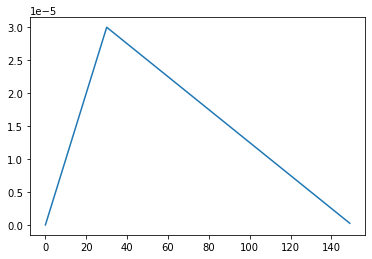

In [9]:
def get_linear_schedule_with_warmup(num_warmup_steps, num_training_steps):
    
    def lrfn(current_step,lr):
        if current_step < num_warmup_steps:
            lr_mul = (float(current_step)+0.0000001) / float(max(1, num_warmup_steps))
        else:
            lr_mul = max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))
        return lr*lr_mul
    
    return lrfn

import matplotlib.pyplot as plt

_lrfn = get_linear_schedule_with_warmup(30,150)
plt.plot([i for i in range(150)], [_lrfn(i,3e-5) for i in range(150)]);
    

# loss & metric

In [10]:
def define_losses_and_metrics():
    with strategy.scope():
        loss_object = tf.keras.losses.BinaryCrossentropy(
            reduction=tf.keras.losses.Reduction.NONE, from_logits=False)

        def compute_loss(labels, predictions):
            per_example_loss = loss_object(labels, predictions)
            loss = tf.nn.compute_average_loss(
                per_example_loss, global_batch_size = global_batch_size)
            return loss

        train_accuracy_metric = tf.keras.metrics.AUC(name='training_AUC')

    return compute_loss, train_accuracy_metric




# training

In [11]:
class train:
    def __init__(self,
                 train_dist_dataset=None, 
                 val_dist_dataset=None, 
                 y_val=None,
                 total_steps=2000, 
                 validate_every=200,
                 model=None, 
                 optimizer_transformer=None,
                 optimizer_head=None, 
                 compute_loss=None,
                 train_accuracy_metric=None,
                 dir_name='transformer_ptm'):

        
        self.model = model
        self.optimizer_transformer = optimizer_transformer
        self.optimizer_head = optimizer_head
        self.compute_loss = compute_loss
        self.train_accuracy_metric = train_accuracy_metric 
        self.dir_name = dir_name
        
        self.do_train(train_dist_dataset, val_dist_dataset, y_val, total_steps, validate_every)
        
    def do_train(self,
                 train_dist_dataset,
                 val_dist_dataset,
                 y_val=None,
                 total_steps=2000,
                 validate_every=200):
        
        best_weights, history = None, []
        scheduler = get_linear_schedule_with_warmup(total_steps//3,total_steps)
        step = 0
        
        for tensor in tqdm(train_dist_dataset, desc="training"):
            K.set_value(self.optimizer_transformer.lr, 
                        scheduler(step,float(LR_TRANSFORMER)))
            K.set_value(self.optimizer_head.lr, 
                        scheduler(step,float(LR_HEAD)))

            self.distributed_train_step(tensor) 
            step+=1


            if (step % validate_every == 0):   
                train_metric = self.train_accuracy_metric.result().numpy()

                val_metric = roc_auc_score(y_val, self.predict(val_dist_dataset))

                print("Step {}, train AUC: {:.5f}  val AUC: {:.5f}".format(step, train_metric, val_metric)) 

                history.append(val_metric)
                if history[-1] == max(history):
                    best_weights = self.model.get_weights()
                    print('best model...')

                self.train_accuracy_metric.reset_states()
#             if self.step%10==0:
#                 print(self.step)
            
            if step  == total_steps:
                break

        self.model.set_weights(best_weights)
        
#         save_model(self.model, self.dir_name)
        
#         print('save done')

    @tf.function
    def distributed_train_step(self, data):
        strategy.experimental_run_v2(self.train_step, args=(data,))

    def train_step(self, inputs):
        features, labels = inputs

        transformer_trainable_variables = [ v for v in self.model.trainable_variables 
                                           if (('pooler' not in v.name)  and 
                                               ('custom' not in v.name))]
        head_trainable_variables = [ v for v in self.model.trainable_variables 
                                    if 'custom'  in v.name]

        # calculate the 2 gradients ( note persistent, and del)
        with tf.GradientTape(persistent=True) as tape:
            predictions = self.model(features, training=True)
            loss = self.compute_loss(labels, predictions)

            self.optimizer_transformer.apply_gradients(zip(tape.gradient(loss, transformer_trainable_variables), 
                                                      transformer_trainable_variables))
            self.optimizer_head.apply_gradients(zip(tape.gradient(loss, head_trainable_variables), 
                                               head_trainable_variables))
        del tape
        del transformer_trainable_variables,head_trainable_variables

        self.train_accuracy_metric.update_state(labels, predictions)
        gc.collect()


    def predict(self,dataset):  
        predictions = []
        for tensor in dataset:
            predictions.append(self.distributed_prediction_step(tensor))
        ### stack replicas and batches
        predictions = np.vstack(list(map(np.vstack,predictions)))
        return predictions

    @tf.function
    def distributed_prediction_step(self,data):
        predictions = strategy.experimental_run_v2(self.prediction_step, args=(data,))
        return strategy.experimental_local_results(predictions)

    def prediction_step(self,inputs):
        features = inputs  # note datasets used in prediction do not have labels
        predictions = self.model(features, training=False)
        return predictions
    
    
def save_model(model, transformer_dir='transformer_ptm'):
    """
    Special function to load a keras model that uses a transformer layer
    """
    transformer = model.layers[1]
    if not os.path.exists(transformer_dir):
        os.makedirs(transformer_dir)
    transformer.save_pretrained(transformer_dir)
    custom_head = model.get_layer('custom_head').get_weights()
    pickle.dump(custom_head, open(os.path.join(transformer_dir,'custom_head.pickle'), 'wb'))

def load_model(transformer_dir='transformer_ptm'):
    """
    Special function to load a keras model that uses a transformer layer
    """
    transformer = TFRobertaModel.from_pretrained(transformer_dir)
    model = build_model(transformer)
    custom_head = pickle.load(open(os.path.join(transformer_dir,'custom_head.pickle'), 'rb'))
    model.get_layer('custom_head').set_weights(custom_head)

    return model

In [12]:
# model, optimizer_transformer, optimizer_head = create_model_and_optimizer()
# save_model(model, transformer_dir='transformer_ptm')

# stage 1 :  data distribution for generalization

In [13]:
def load_jigsaw_trans(langs=['tr','it','es','ru','fr','pt'], 
                      columns=['comment_text', 'toxic','id']):
    train_6langs=[]
    
    train1_df = pd.read_csv(D+'jigsaw-toxic-comment-train.csv')
    train_6langs.append(train1_df.sort_values(by='id').reset_index(drop=True)[columns])

    for i in range(len(langs)):

        fn = D_TRANS+'jigsaw-toxic-comment-train-google-%s.csv'%langs[i]
        t_t_df = pd.read_csv(fn).sort_values(by='id').reset_index(drop=True)
        t_t_df.toxic = t_t_df.toxic.apply(lambda x:eval(x))
        train_6langs.append(t_t_df[columns])
    
    perm_mat = np.zeros((223549,7))
    for i in range(223549):
        perm_mat[i,:] = np.random.permutation(7)
        
    train_fold_7 = []
    for fold in range(7):
        fold_df = []
        for idx_df,df in enumerate(train_6langs):
            fold_df.append(df.loc[[idx for idx,choice in enumerate(perm_mat[:,fold]) if choice==idx_df]].copy())
        fold_df = pd.concat(fold_df).sort_values(by='id').reset_index(drop=True)
        
        fold_df[~fold_df.toxic.apply(lambda x:isinstance(x,int))] = train_6langs[0][~fold_df.toxic.apply(lambda x:isinstance(x,int))]
        
        concat_fold_df = [downsample(fold_df.sample(frac=1.0)) for _ in range(2)]

    
        train_fold_7.append(pd.concat(concat_fold_df))
        
#     train_6langs.append(pseudo_df[columns])
    
    return train_fold_7  #pd.concat(train_6langs)#.sample(frac=1.0,random_state=2048)

def downsample(df):
    """Subsample the train dataframe to 50%-50%"""
    ds_df= pd.concat([
        df.query('toxic>=0.5'),
        df.query('toxic<0.5').sample(df.query('toxic>=0.5').shape[0])
    ])
    
    return ds_df.sample(frac=1.0)
    

train_7fold_df = load_jigsaw_trans()
val_df = pd.read_csv(D+'validation.csv')
test_df = pd.read_csv(D+'test.csv')
sub_df = pd.read_csv(D+'sample_submission.csv')
train_7fold_df[0].shape,val_df.shape,test_df.shape,sub_df.shape

((85536, 3), (8000, 4), (63812, 3), (63812, 2))

In [14]:
# X_val_s2.shape, y_val_s2.shape

In [15]:
%%time
TOTAL_STEPS_STAGE1 = 800
VALIDATE_EVERY_STAGE1 = 200
TOTAL_STEPS_STAGE2 = 200
VALIDATE_EVERY_STAGE2 = 10

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_TOKENIZER)
X_val = regular_encode(val_df.comment_text.values, tokenizer, maxlen=MAX_LEN)
X_test = regular_encode(test_df.content.values, tokenizer, maxlen=MAX_LEN)
y_val = val_df.toxic.values.reshape(-1,1).astype('int64')


# s2 data
X_train_s2 = regular_encode(val_df.comment_text.values, tokenizer, maxlen=MAX_LEN)
y_train_s2 = val_df.toxic.values.reshape(-1,1)

val_s2_df = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
val_s2_df = val_s2_df.sample(len(X_train_s2),random_state=2020)

X_val_s2 = regular_encode(val_s2_df.comment_text.values, tokenizer, maxlen=MAX_LEN)
y_val_s2 = val_s2_df.toxic.values.reshape(-1,1)

print('stage2 shape {}'.format(len(X_train_s2)//global_batch_size))
gc.collect()

# Train_class_list = []

preds = []

for fold in range(4,7):
    K.clear_session()
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    X_train = regular_encode(train_7fold_df[fold].comment_text.values, tokenizer, maxlen=MAX_LEN)

    y_train = train_7fold_df[fold].toxic.values.reshape(-1,1).astype('int64')
    
    train_dist_dataset = create_dist_dataset(X_train, y_train, True)
    val_dist_dataset   = create_dist_dataset(X_val)
    test_dist_dataset  = create_dist_dataset(X_test)

    print('train dataset shape {}'.format(len(X_train)//global_batch_size))

    model, optimizer_transformer, optimizer_head = create_model_and_optimizer()
    compute_loss, train_accuracy_metric = define_losses_and_metrics()

    Train_class = train(train_dist_dataset=train_dist_dataset, 
                      val_dist_dataset=val_dist_dataset, 
                      y_val=y_val,
                      total_steps=TOTAL_STEPS_STAGE1, 
                      validate_every=VALIDATE_EVERY_STAGE1,
                      model=model, 
                      optimizer_transformer=optimizer_transformer, 
                      optimizer_head=optimizer_head, 
                      compute_loss=compute_loss, 
                      train_accuracy_metric=train_accuracy_metric,
                      dir_name=f'transformer_ptm_fold_{fold}',
                     )
    # stage2 --
    TOTAL_STEPS_STAGE2 = 100
    VALIDATE_EVERY_STAGE2 = 10

    # make a datasets
    train_dist_dataset_s2 = create_dist_dataset(X_train_s2, y_train_s2, training=True)
    train_dist_dataset_s21 = create_dist_dataset(X_train_s2, y_train_s2)
    val_dist_dataset_s2 = create_dist_dataset(X_val_s2, y_val_s2)

    # train again
    Train_class.do_train(train_dist_dataset_s2, train_dist_dataset_s21, y_train_s2,
                          total_steps = TOTAL_STEPS_STAGE2, 
                          validate_every = VALIDATE_EVERY_STAGE2)
    
    
    preds.append(Train_class.predict(test_dist_dataset)[:,0])
    
    
#     val_df['toxic'] = Train_class.predict(val_dist_dataset)[:,0]
#     test_df['toxic'] = Train_class.predict(test_dist_dataset)[:,0]
#     val_df.to_csv(f'pseudo_val_fold{fold}.csv', index=False);
#     test_df.to_csv(f'pseudo_test_fold{fold}.csv', index=False);
    del X_train,y_train,train_dist_dataset,val_dist_dataset,test_dist_dataset
    del model,optimizer_transformer,optimizer_head,compute_loss,train_accuracy_metric
    gc.collect()

stage2 shape 62
train dataset shape 668


training: 0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)
training: 199it [03:25,  2.51it/s]

Step 200, train AUC: 0.67821  val AUC: 0.90613


training: 200it [04:08, 13.07s/it]

best model...


training: 399it [05:27,  2.46it/s]

Step 400, train AUC: 0.94877  val AUC: 0.94380


training: 400it [05:43,  4.98s/it]

best model...


training: 599it [07:03,  2.41it/s]

Step 600, train AUC: 0.96596  val AUC: 0.94620


training: 600it [07:18,  4.93s/it]

best model...


training: 799it [08:47,  1.51it/s]

Step 800, train AUC: 0.96895  val AUC: 0.94616



training: 9it [00:03,  2.48it/s]

Step 10, train AUC: 0.94791  val AUC: 0.94664


training: 10it [00:45, 12.81s/it]

best model...


training: 19it [00:48,  1.11s/it]

Step 20, train AUC: 0.92249  val AUC: 0.94793


training: 20it [01:04,  5.44s/it]

best model...


training: 29it [01:07,  1.45it/s]

Step 30, train AUC: 0.92770  val AUC: 0.95152


training: 30it [01:23,  5.15s/it]

best model...


training: 39it [01:26,  1.49it/s]

Step 40, train AUC: 0.94216  val AUC: 0.95323


training: 40it [01:41,  5.01s/it]

best model...


training: 49it [01:44,  1.51it/s]

Step 50, train AUC: 0.92980  val AUC: 0.95555


training: 50it [01:59,  5.00s/it]

best model...


training: 59it [02:03,  1.51it/s]

Step 60, train AUC: 0.93844  val AUC: 0.95772


training: 60it [02:18,  5.06s/it]

best model...


training: 69it [02:21,  1.49it/s]

Step 70, train AUC: 0.95322  val AUC: 0.95861


training: 70it [02:38,  5.58s/it]

best model...


training: 79it [02:42,  1.42it/s]

Step 80, train AUC: 0.94256  val AUC: 0.95895


training: 80it [03:00,  6.04s/it]

best model...


training: 89it [03:04,  1.36it/s]

Step 90, train AUC: 0.94779  val AUC: 0.95946


training: 90it [03:19,  5.21s/it]

best model...


training: 99it [03:23,  1.47it/s]

Step 100, train AUC: 0.95130  val AUC: 0.95956


training: 99it [03:38,  2.21s/it]

best model...


train dataset shape 668


training: 0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)
training: 199it [03:24,  2.49it/s]

Step 200, train AUC: 0.69737  val AUC: 0.93483


training: 200it [04:06, 12.97s/it]

best model...


training: 399it [05:26,  2.50it/s]

Step 400, train AUC: 0.95086  val AUC: 0.94343


training: 400it [05:41,  4.84s/it]

best model...


training: 599it [07:01,  2.48it/s]

Step 600, train AUC: 0.96346  val AUC: 0.94350


training: 600it [07:16,  4.87s/it]

best model...


training: 799it [08:36,  2.50it/s]

Step 800, train AUC: 0.96820  val AUC: 0.94502


training: 799it [08:52,  1.50it/s]

best model...



training: 9it [00:03,  2.47it/s]

Step 10, train AUC: 0.92976  val AUC: 0.94570


training: 10it [00:46, 13.10s/it]

best model...


training: 19it [00:49,  1.14s/it]

Step 20, train AUC: 0.92463  val AUC: 0.94675


training: 20it [01:05,  5.56s/it]

best model...


training: 29it [01:08,  1.44it/s]

Step 30, train AUC: 0.93741  val AUC: 0.95033


training: 30it [01:24,  5.17s/it]

best model...


training: 39it [01:27,  1.49it/s]

Step 40, train AUC: 0.93045  val AUC: 0.95185


training: 40it [01:43,  5.27s/it]

best model...


training: 50it [01:56,  3.43s/it]

Step 50, train AUC: 0.93128  val AUC: 0.95160


training: 59it [02:00,  1.75it/s]

Step 60, train AUC: 0.94660  val AUC: 0.95485


training: 60it [02:15,  5.00s/it]

best model...


training: 69it [02:18,  1.51it/s]

Step 70, train AUC: 0.95406  val AUC: 0.95603


training: 70it [02:34,  5.07s/it]

best model...


training: 79it [02:37,  1.50it/s]

Step 80, train AUC: 0.95020  val AUC: 0.95638


training: 80it [02:52,  5.04s/it]

best model...


training: 89it [02:55,  1.51it/s]

Step 90, train AUC: 0.94318  val AUC: 0.95705


training: 90it [03:11,  5.03s/it]

best model...


training: 99it [03:14,  1.51it/s]

Step 100, train AUC: 0.94189  val AUC: 0.95709


training: 99it [03:30,  2.13s/it]

best model...


train dataset shape 668


training: 0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)
training: 199it [03:23,  2.51it/s]

Step 200, train AUC: 0.62247  val AUC: 0.87188


training: 200it [04:05, 12.69s/it]

best model...


training: 399it [05:24,  2.52it/s]

Step 400, train AUC: 0.93954  val AUC: 0.94255


training: 400it [05:39,  4.76s/it]

best model...


training: 599it [06:59,  2.49it/s]

Step 600, train AUC: 0.96480  val AUC: 0.94337


training: 600it [07:14,  4.99s/it]

best model...


training: 799it [08:44,  1.52it/s]

Step 800, train AUC: 0.96764  val AUC: 0.94285



training: 9it [00:03,  2.50it/s]

Step 10, train AUC: 0.92036  val AUC: 0.94467


training: 10it [00:45, 12.76s/it]

best model...


training: 19it [00:48,  1.11s/it]

Step 20, train AUC: 0.92643  val AUC: 0.94501


training: 20it [01:04,  5.47s/it]

best model...


training: 29it [01:07,  1.45it/s]

Step 30, train AUC: 0.92053  val AUC: 0.94807


training: 30it [01:22,  5.04s/it]

best model...


training: 39it [01:25,  1.51it/s]

Step 40, train AUC: 0.92992  val AUC: 0.95005


training: 40it [01:40,  4.99s/it]

best model...


training: 49it [01:44,  1.52it/s]

Step 50, train AUC: 0.93955  val AUC: 0.95314


training: 50it [01:59,  4.99s/it]

best model...


training: 59it [02:02,  1.51it/s]

Step 60, train AUC: 0.93695  val AUC: 0.95430


training: 60it [02:17,  5.09s/it]

best model...


training: 69it [02:21,  1.49it/s]

Step 70, train AUC: 0.94185  val AUC: 0.95626


training: 70it [02:36,  5.04s/it]

best model...


training: 79it [02:39,  1.51it/s]

Step 80, train AUC: 0.95043  val AUC: 0.95717


training: 80it [02:55,  5.03s/it]

best model...


training: 89it [02:58,  1.51it/s]

Step 90, train AUC: 0.93523  val AUC: 0.95772


training: 90it [03:13,  5.03s/it]

best model...


training: 99it [03:16,  1.51it/s]

Step 100, train AUC: 0.94355  val AUC: 0.95794


training: 99it [03:32,  2.14s/it]

best model...


CPU times: user 20min 8s, sys: 6min 39s, total: 26min 48s
Wall time: 54min 27s


# stage 2 : pseudo label

In [16]:
# %%time
# val_df['toxic'] = predict(val_dist_dataset)[:,0]
# test_df['toxic'] = predict(test_dist_dataset)[:,0]
# val_df.to_csv('pseudo_val.csv', index=False);
# test_df.to_csv('pseudo_test.csv', index=False);
# val_df.columns,sub_df.columns,test_df.columns

In [17]:
# pseudo_test_df = pd.read_csv('/kaggle/input/jigsaw-tpu2-dataset/pseudo_test_fold1.csv')
# t_t2 = pd.read_csv('/kaggle/input/jigsaw-tpu2-dataset/pseudo_test_fold0.csv')['toxic']
# pseudo_test_df['toxic'] = (pseudo_test_df['toxic']+t_t2)/2
# pseudo_test_df['comment_text'] = pseudo_test_df['content']

# pseudo_val_df = pd.read_csv('/kaggle/input/jigsaw-tpu2-dataset/pseudo_val_fold1.csv')
# t_t2 = pd.read_csv('/kaggle/input/jigsaw-tpu2-dataset/pseudo_val_fold0.csv')['toxic']
# pseudo_val_df['toxic'] = (pseudo_val_df['toxic']+t_t2)/2

# # /kaggle/input/jigsaw-tpu2/transformer_ptm_fold_0/tf_model.h5
# # /kaggle/input/jigsaw-tpu2/transformer_ptm_fold_0/config.json
# # /kaggle/input/jigsaw-tpu2/transformer_ptm_fold_0/custom_head.pickle
# # /kaggle/input/jigsaw-tpu2/transformer_ptm_fold_1/tf_model.h5
# # /kaggle/input/jigsaw-tpu2/transformer_ptm_fold_1/config.json
# # /kaggle/input/jigsaw-tpu2/transformer_ptm_fold_1/custom_head.pickle

In [18]:
# def load_jigsaw_trans(langs=['tr','it','es','ru','fr','pt'], 
#                       columns=['comment_text', 'toxic','id']):
#     train_6langs=[]
    
#     train1_df = pd.read_csv(D+'jigsaw-toxic-comment-train.csv')
#     train_6langs.append(train1_df.sort_values(by='id').reset_index(drop=True)[columns])

#     for i in range(len(langs)):

#         fn = D_TRANS+'jigsaw-toxic-comment-train-google-%s.csv'%langs[i]
#         t_t_df = pd.read_csv(fn).sort_values(by='id').reset_index(drop=True)
#         t_t_df.toxic = t_t_df.toxic.apply(lambda x:eval(x))
#         train_6langs.append(t_t_df[columns])
    
#     perm_mat = np.zeros((223549,7))
#     for i in range(223549):
#         perm_mat[i,:] = np.random.permutation(7)
        
#     train_fold_7 = []
#     for fold in range(7):
#         fold_df = []
#         for idx_df,df in enumerate(train_6langs):
#             fold_df.append(df.loc[[idx for idx,choice in enumerate(perm_mat[:,fold]) if choice==idx_df]].copy())
#         fold_df = pd.concat(fold_df).sort_values(by='id').reset_index(drop=True)
        
#         fold_df[~fold_df.toxic.apply(lambda x:isinstance(x,int))] = train_6langs[0][~fold_df.toxic.apply(lambda x:isinstance(x,int))]
        
#         concat_fold_df = [downsample(fold_df.sample(frac=1.0)) for _ in range(2)]
        
# #         pseudo_path = f'/kaggle/input/jigsaw-tpu2/pseudo_test_fold{fold}.csv'
# #         if os.path.exists(pseudo_path):
# #             pseudo_test_df = pd.read_csv(f'/kaggle/input/jigsaw-tpu2/pseudo_test_fold{fold}.csv')
# #             pseudo_val_df = pd.read_csv(f'/kaggle/input/jigsaw-tpu2/pseudo_val_fold{fold}.csv')
# #             pseudo_test_df['comment_text'] = pseudo_test_df['content']
        
# #             concat_fold_df.append(downsample(pseudo_val_df.sample(frac=1.0)))
# #             concat_fold_df.append(downsample(pseudo_test_df.sample(frac=1.0)))
        
#         concat_fold_df.append(downsample(pseudo_val_df.sample(frac=1.0)))
#         concat_fold_df.append(downsample(pseudo_test_df.sample(frac=0.8)))
        
#         train_fold_7.append(pd.concat(concat_fold_df).sample(frac=1.0))
        
# #     train_6langs.append(pseudo_df[columns])
    
#     return train_fold_7  #pd.concat(train_6langs)#.sample(frac=1.0,random_state=2048)

# def downsample(df):
#     """Subsample the train dataframe to 50%-50%"""
#     ds_df= pd.concat([
#         df.query('toxic>=0.5'),
#         df.query('toxic<0.5').sample(df.query('toxic>=0.5').shape[0])
#     ])
    
#     return ds_df.sample(frac=1.0)
    

# train_7fold_df = load_jigsaw_trans()
# val_df = pd.read_csv(D+'validation.csv')
# test_df = pd.read_csv(D+'test.csv')
# sub_df = pd.read_csv(D+'sample_submission.csv')
# train_7fold_df[0].shape,val_df.shape,test_df.shape,sub_df.shape

In [19]:
# %%time
# TOTAL_STEPS_STAGE1 = 800
# VALIDATE_EVERY_STAGE1 = 200
# TOTAL_STEPS_STAGE2 = 200
# VALIDATE_EVERY_STAGE2 = 10

# tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_TOKENIZER)
# X_val = regular_encode(val_df.comment_text.values, tokenizer, maxlen=MAX_LEN)
# X_test = regular_encode(test_df.content.values, tokenizer, maxlen=MAX_LEN)
# y_val = val_df.toxic.values.reshape(-1,1).astype('int64')

# Train_class_list = []
# for fold in range(3):
#     K.clear_session()
#     tf.tpu.experimental.initialize_tpu_system(tpu)
    
#     X_train = regular_encode(train_7fold_df[fold].comment_text.values, tokenizer, maxlen=MAX_LEN)

#     y_train = train_7fold_df[fold].toxic.values.reshape(-1,1).astype('int64')
    
#     train_dist_dataset = create_dist_dataset(X_train, y_train, True)
#     val_dist_dataset   = create_dist_dataset(X_val)
#     test_dist_dataset  = create_dist_dataset(X_test)

#     print('train dataset shape {}'.format(len(X_train)//global_batch_size))

    
#     model_path = f'/kaggle/input/jigsaw-tpu2/transformer_ptm_fold_{fold}'
#     if os.path.exists(model_path):
#         with strategy.scope():
#             model = load_model(model_path)
#             optimizer_transformer = Adam(learning_rate=LR_TRANSFORMER)
#             optimizer_head = Adam(learning_rate=LR_HEAD)
#     else:
#         model, optimizer_transformer, optimizer_head = create_model_and_optimizer()
        
#     compute_loss, train_accuracy_metric = define_losses_and_metrics()

#     Train_class_list.append(
#         train(train_dist_dataset=train_dist_dataset, 
#                       val_dist_dataset=val_dist_dataset, 
#                       y_val=y_val,
#                       total_steps=TOTAL_STEPS_STAGE1, 
#                       validate_every=VALIDATE_EVERY_STAGE1,
#                       model=model, 
#                       optimizer_transformer=optimizer_transformer, 
#                       optimizer_head=optimizer_head, 
#                       compute_loss=compute_loss, 
#                       train_accuracy_metric=train_accuracy_metric,
#                       dir_name=f'transformer_ptm_fold_{fold}',
#                      ))
# #     train(train_dist_dataset, val_dist_dataset, y_val,
# #           TOTAL_STEPS_STAGE1, VALIDATE_EVERY_STAGE1, dir_name=f'transformer_ptm_fold_{fold}')
    
# #     val_df['toxic'] = Train_class.predict(val_dist_dataset)[:,0]
# #     test_df['toxic'] = Train_class.predict(test_dist_dataset)[:,0]
# #     val_df.to_csv(f'pseudo_val_fold{fold}.csv', index=False);
# #     test_df.to_csv(f'pseudo_test_fold{fold}.csv', index=False);
#     del X_train, y_train, train_dist_dataset, val_dist_dataset, test_dist_dataset
#     gc.collect()
# #     del model,optimizer_transformer,optimizer_head,compute_loss,train_accuracy_metric

# stage3: finetune in val data

In [20]:
# TOTAL_STEPS_STAGE2 = 100
# VALIDATE_EVERY_STAGE2 = 10

# # make a datasets
# train_dist_dataset = create_dist_dataset(X_train_s2, y_train_s2, training=True)
# train_dist_dataset1 = create_dist_dataset(X_train_s2, y_train_s2)
# val_dist_dataset = create_dist_dataset(X_val_s2, y_val_s2)

# # train again
# for Train_class in Train_class_list:
#     Train_class.do_train(train_dist_dataset, train_dist_dataset1, y_train_s2,
#                           total_steps = TOTAL_STEPS_STAGE2, 
#                           validate_every = VALIDATE_EVERY_STAGE2)  # not validating but printing now
# gc.collect()

## Make predictions and submission

In [21]:
%%time

sub_df['toxic'] = sum(preds)/len(preds)
sub_df.to_csv('submission.csv', index=False)

CPU times: user 340 ms, sys: 32.2 ms, total: 372 ms
Wall time: 692 ms
